In [2]:
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Enable inline plots
%matplotlib inline

In [4]:
#Import the streamflow data CSV and format columns
df=pd.read_csv('GageData.csv',dtype={'site_no':'str'},parse_dates=['datetime'])

In [5]:
#Add year, month, and water_year columns
df['year'] = df['datetime'].map(lambda x: x.year)
df['month'] = df['datetime'].map(lambda x: x.month)
df['water_year'] = df['datetime'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

In [6]:
#Compute flow in cms
df['MeanFlow_cms'] = df['MeanFlow_cfs'] * 0.028316847 

In [7]:
#Set the index to full date
df.index = df.datetime

### Compute total monthly stream flow
Group by month and year, computing total discharge for all days in each month.

In [24]:
#Group data on water_year
groupObj = df.groupby(('year','month'))
sMonthlyFlow = groupObj['MeanFlow_cms'].sum()
#Convert series to dataframe
dfMonthlyFlow = sMeanFlow.to_frame()
dfMonthlyFlow.head()

MeanFlow_cms
year month              
1930 10       161.802464
     11       246.498153
     12       638.941336
1931 1        801.989741
     2        377.973274

### Compute the 7-month rolling average of monthly stream flow

In [35]:
#Compute 7 month rolling average
dfMonthlyFlow['7Q'] = dfMonthlyFlow.rolling(window=7,min_periods=7).mean()
dfMonthlyFlow.head(10)

MeanFlow_cms          7Q
year month                          
1930 10       161.802464         NaN
     11       246.498153         NaN
     12       638.941336         NaN
1931 1        801.989741         NaN
     2        377.973274         NaN
     3        628.888855         NaN
     4       1587.867196  634.851574
     5       1612.984239  842.163256
     6        457.373713  872.288336
     7        871.196115  905.467590

### Compute min of 7Q for each year

In [37]:
dfLowFlow = dfMonthlyFlow.groupby('year')['7Q'].min().to_frame()
#Drop null records
dfLowFlow.dropna(inplace=True)

dfLowFlow.head()

,7Q
year,
1931,634.851574
1932,401.399397
1933,184.913056
1934,163.958589
1935,505.241320


#### Compute return interval and probability of recurrence

In [39]:
### Compute rankings
dfLowFlow['rank'] = dfLowFlow.rank(ascending=True)
dfLowFlow.sort_values(by='7Q',ascending=True,inplace=True)

In [41]:
# Compute Return Interval
countRecs = dfLowFlow['rank'].max()
dfLowFlow['RI'] = (countRecs + 1) / dfLowFlow['rank']

In [42]:
# Compute probability of recurrence (POR)
dfLowFlow['Pe'] = 1 / dfLowFlow['RI'] * 100

In [43]:
dfLowFlow.head()

,7Q,rank,RI,Pe
year,,,,
1934,163.958589,1.0,88.000000,1.136364
1981,173.772400,2.0,44.000000,2.272727
1933,184.913056,3.0,29.333333,3.409091
1942,226.385101,4.0,22.000000,4.545455
1980,226.708722,5.0,17.600000,5.681818


### SANDBOX

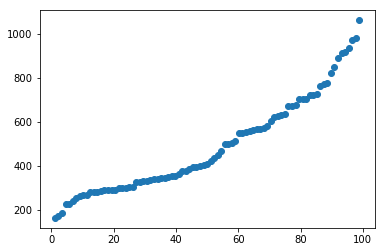

In [48]:
x = dfLowFlow['Pe']
y = dfLowFlow['7Q']

plt.scatter(x,y);

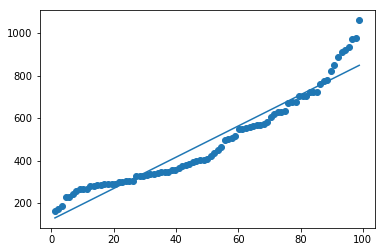

In [61]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:,np.newaxis],y)

xfit = np.linspace(x.min(),x.max(),100)
yfit = model.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit,yfit);

In [64]:
print("Slope : ", model.coef_[0])
print("Intercept", model.intercept_)

Slope :  7.35011343584
Intercept 121.901834475


### Compute the regression using NumPy functions

In [ ]:
x = dfAnnualLow['Pe']
y = dfAnnualLow['7Q']

In [ ]:
# Compute the slope and intercept using the polyfit
regSlope, regIntercept = np.polyfit(np.log(x), y, 1)
print(regSlope, regIntercept)

In [ ]:
#Convert the regression components into a printable formula
regText = "y = {0:.1f}x + {1:.1f}".format(regSlope,regIntercept)
print(regText)

In [ ]:
# Compute p
p = np.poly1d(regSlope, regIntercept)
print(p.r)

### Plotting
https://seaborn.pydata.org/tutorial/regression.html
https://seaborn.pydata.org/generated/seaborn.regplot.html#seaborn.regplot

In [ ]:
#Set the style to use Seaborn
sns.set(color_codes=True,font_scale=2)

In [ ]:
from scipy.optimize import curve_fit

# define type of function to search; here it's exponential
def exponential_func(x, a, b, c):
    return a*np.exp(-b*x)+c

# curve fit
popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))
print (pcov)
print (popt)

In [ ]:
# test result
x2 = np.linspace(0, 100, 25)
exponential_func(x2, popt)

fig, ax = plt.subplots()
ax.plot(x2, y2, color='r', label='Fit. func: $f(x) = %.3f e^{%.3f x} %+.3f$' % (a,k,b))
ax.plot(x, y, 'bo', label='data with noise')
ax.legend(loc='best')
plt.show()

In [ ]:
#dfAnnualLow['7Qexp'] = np.exp(dfAnnualLow['7Q'])
dfAnnualLow['ln7Q'] = np.log(dfAnnualLow['7Q'])

In [ ]:
#Create the canvas (fig) and axes (ax) objects, setting the figure size
fig, ax = plt.subplots(figsize=(20,6))

#Set axis properties
ax.set(xlim=(1,100),
       ylim=(0,1200),
#       xscale ="",
       label=regText
      )

#Plot the data
ax = sns.regplot(x='Pe',
                 y='ln7Q',
                 data=dfAnnualLow,
                 logx=False,
                 fit_reg=True,
                 ci=None)

#Set the axis labels.
ax.set(xlabel='Probability of recurrance (%)', 
       ylabel='Peak discharge(cms)',
       title=regText
      )

In [ ]:
#Compute Peak discharges from 100, 500, and 1000 year intervals
for RI in (100,500,1000):
    #Compute peak discharge from RI
    peakFlow = (np.log(RI) * regSlope) + regIntercept
    #Add to the plot
    ax.plot(RI,peakFlow,'rs',markersize=8) #'rs' = red square markers

## Plot pre vs post Falls Lake 1980 data

In [ ]:
#Set the TimeSet variable to pre or post, using index (i.e. year) values 
dfMA.loc[dfMA.index < 1980,'TimeSet'] = 'PreFallsLake'
dfMA.loc[dfMA.index >= 1984,'TimeSet'] = 'PostFallsLake'

In [ ]:
#Plot multiple frames using Seaborn's FacetGrids

#Create the Facets based on values in the TimeSet field (Set above)
g = sns.FacetGrid(dfMA,col='TimeSet',size=10,legend_out=True)

#Add the regression plot to each facet
g.map(sns.regplot,'RI','MeanFlow_cms',
      data=dfMA,
      logx=True,
      fit_reg=True,
      ci=None)

#Set the axis values
for ax in g.axes.flat:
    ax.set(xlim=(0,700),  
           ylim=(0,700),
           xscale ="log"
          )

In [ ]:
#Create the canvas (fig) and axes (ax) objects, setting the figure size
fig, ax = plt.subplots(figsize=(20,16))

#Set axis properties
ax.set(xlim=(1,1200),
       ylim=(0,1200),
       xscale ="log"
      )

#Plot the data
ax = sns.regplot(x='RI',
                 y='MeanFlow_cms',
                 data=dfMA.loc[dfMA.index < 1980],
                 logx=True,
                 fit_reg=True,
                 ci=None,
                 label='Pre'
                )

#Plot the data
ax = sns.regplot(x='RI',
                 y='MeanFlow_cms',
                 data=dfMA.loc[dfMA.index >= 1984],
                 logx=True,
                 fit_reg=True,
                 ci=None,
                 label='Post'
                )

#Set the axis labels.
ax.set(xlabel='Return Interval (years)', 
       ylabel='Peak discharge(cms)'
      )

ax.legend()

#Compute Peak discharges from 100, 500, and 1000 year intervals
for RI in (100,500,1000):
    #Compute peak discharge from RI
    peakFlow = (np.log(RI) * regSlope) + regIntercept
    #Add to the plot
    ax.plot(RI,peakFlow,'rs',markersize=8) #'rs' = red square markers

In [ ]:
#Filter the data
dfPre = df[:'1979-12-31']

#Sort the records
dfPre.sort_values(by='MeanFlow_cms',ascending=False)

#Group data on water_year
byYear = df.groupby('water_year')

#Compute a series of max annual flow from the grouped data
sPeakFlow = byYear['MeanFlow_cms'].max()
sPeakFlow.name = "PeakFlow_cms"

#Compute rankings
sRank = sPeakFlow.rank(ascending=False)
sRank.name = "rank"

#Combine peakflow and rank series into a dataframe
dfPreMA = pd.concat([sPeakFlow,sRank],axis='columns')

#Count the number of years 
countRecs = dfPreMA['rank'].max()

#Compute Return Interval (RI)
dfPreMA['RI'] = (countRecs + 1) / dfPreMA['rank']

#Compute Probability of exceedance (Pe)
dfPreMA['Pe'] = 1 / dfPreMA['RI']